# ML_K_Nearest_Neighbors

Credits:

- [2021 Python for Machine Learning & Data Science Masterclass by Jose Portilla Udemy](https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/)

K nearest neighbors (KNN) is one of the simplest classification algorithms. While KNN can be used for regression tasks, its performance can be quite poor and less efficient than other algorithms. K-means (Unsupervised learning) is unrelated to KNN (Supervised learning), be careful not to confuse the two due to their similar sounding names!

- It simply assigns a label to new data based on the distance between the old data and new data.
- KNN Algorithm
    - Choose K value.
    - Sort feature vectors (N dimensional space) by distance metric. Distance Metric: many ways to measure distance:
        - Minkowski
        - Euclidean
        - Manhattan
        - Chebyshev

    - Choose class based on K nearest feature vectors.
- Scaling is necessary for KNN as it is using distance metrics to build the model.
- Tie considerations and options:
    - Always choose an odd K.
    - In case of tie,simply reduce K by 1 until tie is broken.
    - Randomly break tie. 
    - Choose nearest class point.

<img src="images/KNN1.png" style="float:center;" width="600"/>


- We want a K value that minimizes error:
    - Error = 1 - Accuracy
- Two methods:
    - Elbow method.    
    - Cross validate a grid search of multiple K values and choose K that results in lowest error or highest accuracy. Cross validation only takes into account the K value with the lowest error rate across multiple folds.

    <img src="images/KNN2.png" style="float:center;" width="600"/>


**Pipleline in Scikit-Learn**
- A Pipeline object in Scikit-Learn can set up a sequence of repeated operations, such as a scaler and a model.
- This way only the pipeline needs to be called, instead of having to repeatedly call a scaler and a model.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data

To understand KNN for classification, we'll work with a simple dataset representing gene expression levels. Gene expression levels are calculated by the ratio between the expression of the target gene (i.e., the gene of interest) and the expression of one or more reference genes (often household genes). This dataset is synthetic and specifically designed to show some of the strengths and limitations of using KNN for Classification.

[More info on gene expression](https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level)

In [17]:
# Data
df = pd.read_csv('data/gene_expression.csv')
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


## EDA

<AxesSubplot:xlabel='Cancer Present', ylabel='count'>

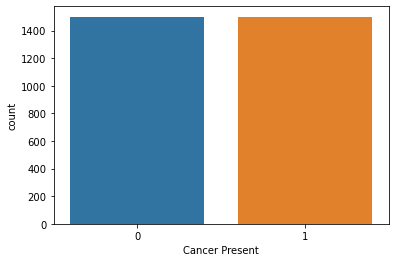

In [30]:
sns.countplot(x='Cancer Present',data=df)

- Perfectly balanced data

(4.0, 8.0)

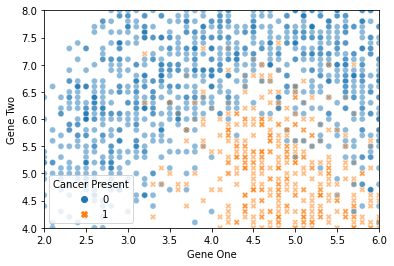

In [31]:
sns.scatterplot(data=df,x='Gene One',y='Gene Two',
                hue='Cancer Present',alpha=0.5,
                style='Cancer Present');
plt.xlim(2,6)
plt.ylim(4,8)

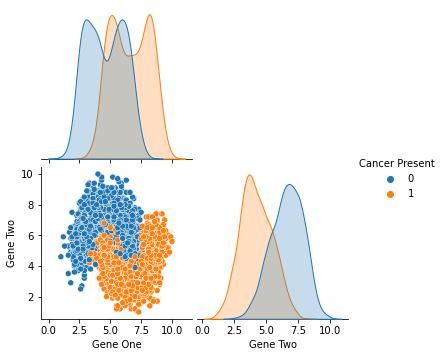

In [32]:
sns.pairplot(df,hue='Cancer Present',corner=True);

## KNN

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report

X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train,y_train)

y_pred = knn_model.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[420  50]
 [ 47 383]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       470
           1       0.88      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



### Elbow Method

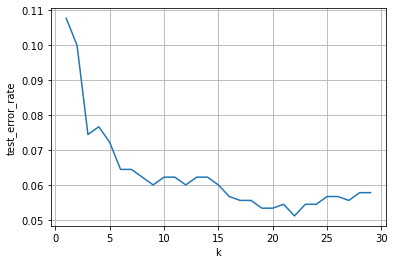

In [43]:
from sklearn.metrics import accuracy_score

test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train,y_train)
    y_pred = knn_model.predict(X_test)
    test_error_rates.append(1-accuracy_score(y_test,y_pred))
    
plt.plot(range(1,30),test_error_rates)
plt.xlabel('k')
plt.ylabel('test_error_rate')
plt.grid()

### Pipeline

Using a Pipeline object to set up a workflow of operations:
- Scale Data
- Create Model on Scaled Data


*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

In [48]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling will be done within the Pipeline

In [49]:
scalar = StandardScaler()
knn = KNeighborsClassifier()

In [50]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [51]:
from sklearn.pipeline import Pipeline
operations = [('scalar',scalar),('knn',knn)]
pipe = Pipeline(operations)

Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

In [56]:
from sklearn.model_selection import GridSearchCV
k_values = list(range(1,20))
param_grid = {'knn__n_neighbors':k_values}
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,
                                  scoring='accuracy')
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [55]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scalar', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=14))],
 'verbose': False,
 'scalar': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=14),
 'scalar__copy': True,
 'scalar__with_mean': True,
 'scalar__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 14,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [59]:
full_pred = full_cv_classifier.predict(X_test)

print(classification_report(y_test,full_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       470
           1       0.95      0.92      0.93       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [63]:
new_gene = [[3.8,6.3]]
full_cv_classifier.predict(new_gene)

array([0])

In [64]:
full_cv_classifier.predict_proba(new_gene)

array([[0.92857143, 0.07142857]])